In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# reading all datasets
country19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country18_df = pd.read_csv('data\Erasmus18.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country17_df = pd.read_csv('data\Erasmus17.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country16_df = pd.read_csv('data\Erasmus16.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country15_df = pd.read_csv('data\Erasmus15.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country14_df = pd.read_csv('data\Erasmus14.csv', sep=';',low_memory=False, header=0, encoding='utf8')

# merging all datasets
df = country19_df.append(country18_df)
df = df.append(country17_df)
df = df.append(country16_df)
df = df.append(country15_df)
df = df.append(country14_df)

In [3]:
# reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA1%20mobilities%20eligible%20finalised%20started%20in%202018.csv?inline=false')
# reply.encoding = 'utf-8'
# csv_data = reply.text
# df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)

for i, name in enumerate(df.columns):
    print(i, name)
df.drop(columns=['GroupLeader', 'Sending Organisation Erasmus Code', 'Receiving Organisation Erasmus Code'], inplace=True)
c_df = df.copy() # we will use it for later (country network)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 GroupLeader
14 Participant Age
15 Sending Country Code
16 Sending City
17 Sending Organization
18 Sending Organisation Erasmus Code
19 Receiving Country Code
20 Receiving City
21 Receiving Organization
22 Receiving Organisation Erasmus Code
23 Participants


In [4]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2016-3-EE01-KA105-034520,2019-2020,2019-03,2019-04,33.0,European Voluntary Service - Partner Countries,? Unknown ?,EE,??? - ? Unknown ?,Female,Learner,No,No,18,EE,TALLINN,MTÜ NOORTEVAHETUSE ARENGU ÜHING ESTYES,RU,Nizhny Novgorod,Interregional youth social movement of support...,1
1,2016-3-UK01-KA105-035288,2019-2020,2019-02,2019-03,56.0,European Voluntary Service - Partner Countries,? Unknown ?,IT,??? - ? Unknown ?,Male,Learner,No,Yes,29,IT,TRAPPETO,CESIE,UK,Cardiff,Language Academy Wales,1
2,2017-1-AT01-KA101-034705,2019-2020,2019-04,2019-04,6.0,Structured Courses/Training Events,Languages,AT,??? - ? Unknown ?,Female,Staff,No,No,39,AT,Hollabrunn,HTL Für Lebensmitteltechnologie-Lebensmittelsi...,EL,Heraklion,Institut für europäische Lehrerfortbildung UG ...,1
3,2017-1-AT01-KA101-034727,2019-2020,2019-02,2019-02,15.0,Structured Courses/Training Events,Teacher training with subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,27,AT,Weiz,BHAK/BHAS Weiz,IE,Dublin,Atlantic Language Dublin,1
4,2017-1-AT01-KA101-034774,2019-2020,2019-02,2019-02,5.0,Structured Courses/Training Events,Education,AT,??? - ? Unknown ?,Female,Staff,No,No,26,AT,Linz,Bundesbildungsanstalt für Elementarpädagogik,MT,St.Julian's,Executive Training Institute Ltd.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235409,2014-3-SE02-KA105-001055,2014-2015,2014-07,2014-07,9.0,Mobility of youth workers - Partner Countries,? Unknown ?,SI,??? - ? Unknown ?,Male,Staff,No,No,-1,SI,Slovenj Gradec,JZ Spotur,GE,Tbilisi,"Non Formal Education Youth Centre ""Sunny House""",1
235410,2014-3-SE02-KA105-001055,2014-2015,2014-07,2014-07,9.0,Mobility of youth workers - Partner Countries,? Unknown ?,SI,??? - ? Unknown ?,Male,Staff,No,No,27,SI,Slovenj Gradec,JZ Spotur,GE,Tbilisi,"Non Formal Education Youth Centre ""Sunny House""",1
235411,2014-3-SE02-KA105-001055,2014-2015,2014-07,2014-07,9.0,Mobility of youth workers - Partner Countries,? Unknown ?,TR,??? - ? Unknown ?,Female,Staff,No,No,25,TR,Istanbul,Toplum Gonulluleri Vakfi,GE,Tbilisi,"Non Formal Education Youth Centre ""Sunny House""",1
235412,2014-3-SE02-KA105-001055,2014-2015,2014-07,2014-07,9.0,Mobility of youth workers - Partner Countries,? Unknown ?,UA,??? - ? Unknown ?,Female,Staff,No,No,22,UA,Kyiv,All-Ukrainian Association for Youth Co-operati...,GE,Tbilisi,"Non Formal Education Youth Centre ""Sunny House""",1


In [5]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 15, 18))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

5410
6505


In [6]:
mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df

Number of Receiving Universities:  5220
Number of Sending Universities:  6253


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending City,Receiving City
276,CHINA FOREIGN AFFAIRS UNIVERSITY,DIPLOMATISCHE AKADEMIE WIEN,1,Student mobility for Studies To/From Partner C...,Beijing,WIEN
277,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,SOUTHERN FEDERAL UNIVERSITY,1,Student mobility for Studies To/From Partner C...,Wien,ROSTOV ON DON
278,SOUTHERN FEDERAL UNIVERSITY,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,Student mobility for Studies To/From Partner C...,ROSTOV ON DON,Wien
279,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,Student mobility for Studies To/From Partner C...,SAINT PETERSBURG,Wien
280,SOUTHERN FEDERAL UNIVERSITY,FACHHOCHSCHULE DES BFI WIEN GESELLSCHAFT M.B.H.,1,Student mobility for Studies To/From Partner C...,ROSTOV ON DON,Wien
...,...,...,...,...,...,...
214990,OXFORD BROOKES UNIVERSITY,POLITECNICO DI TORINO,1,Student mobility for studies between Programme...,OXFORD,TORINO
214991,OXFORD BROOKES UNIVERSITY,POLITECNICO DI TORINO,1,Student mobility for studies between Programme...,OXFORD,TORINO
214992,OXFORD BROOKES UNIVERSITY,UNIVERSIDAD DE ZARAGOZA,1,Student mobility for studies between Programme...,OXFORD,ZARAGOZA
214993,OXFORD BROOKES UNIVERSITY,POLITECNICO DI TORINO,1,Student mobility for studies between Programme...,OXFORD,TORINO


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

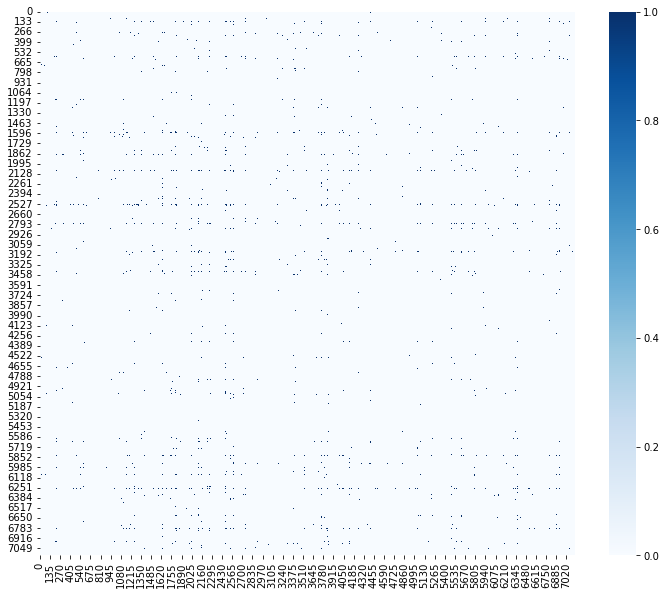

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
uni_cities = mobility_df.copy()
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

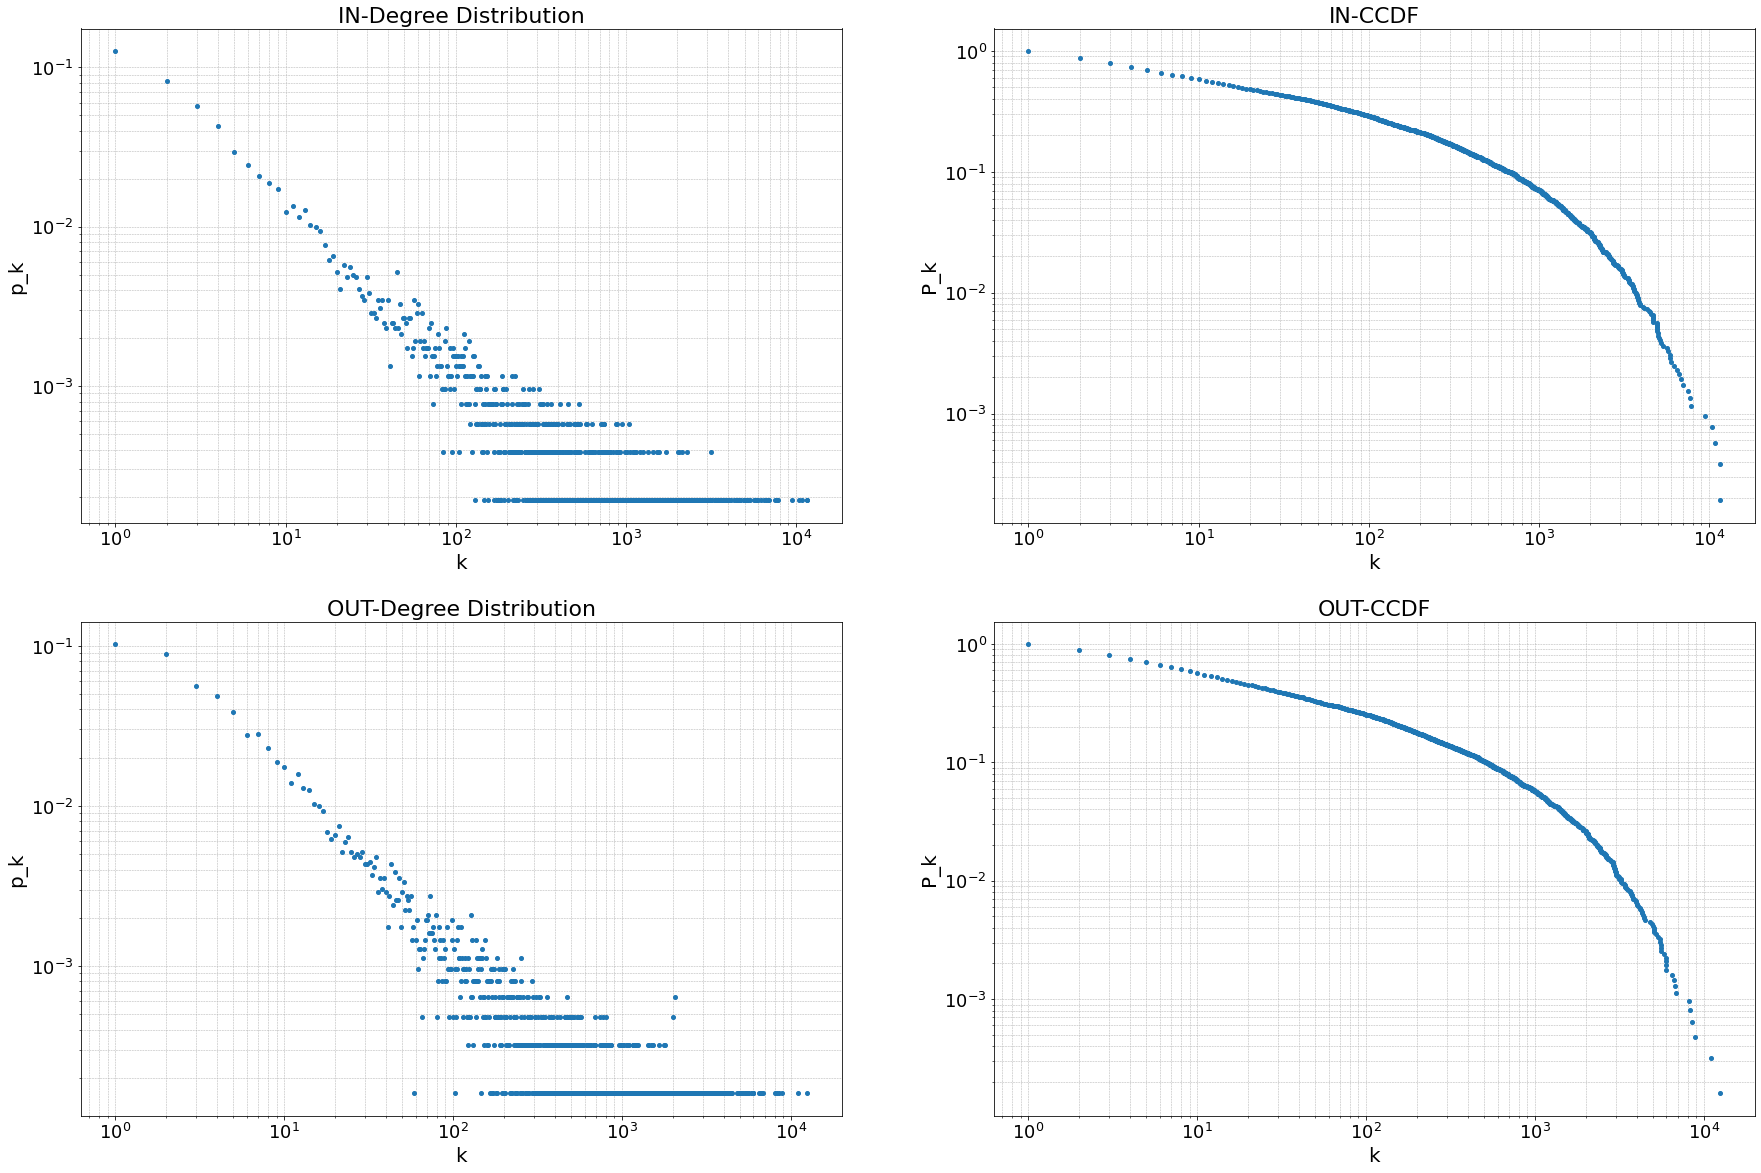

Top 10 for in degree


,Nodes,in degree
5800,UNIVERSITAT DE VALENCIA,11611
6985,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,11540
5288,UNIVERSIDAD DE GRANADA,10809
2631,UNIVERSIDADE DE LISBOA,10424
6238,UNIVERSIDAD COMPLUTENSE DE MADRID,9414
4958,UNIVERSITAT POLITECNICA DE VALENCIA,7854
3497,UNIVERZA V LJUBLJANI,7762
5387,KATHOLIEKE UNIVERSITEIT LEUVEN,7487
4816,UNIVERSIDAD DE SEVILLA,6978
1579,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,6818


Top 10 for out degree


,Nodes,out degree
6985,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,12477
5288,UNIVERSIDAD DE GRANADA,11026
5800,UNIVERSITAT DE VALENCIA,8866
6238,UNIVERSIDAD COMPLUTENSE DE MADRID,8467
623,UNIVERSITA DEGLI STUDI DI PADOVA,8302
3201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,8102
5387,KATHOLIEKE UNIVERSITEIT LEUVEN,6867
4514,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,6700
3364,UNIVERSITA DEGLI STUDI DI TORINO,6664
5806,UNIVERSIDAD POLITECNICA DE MADRID,6446


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

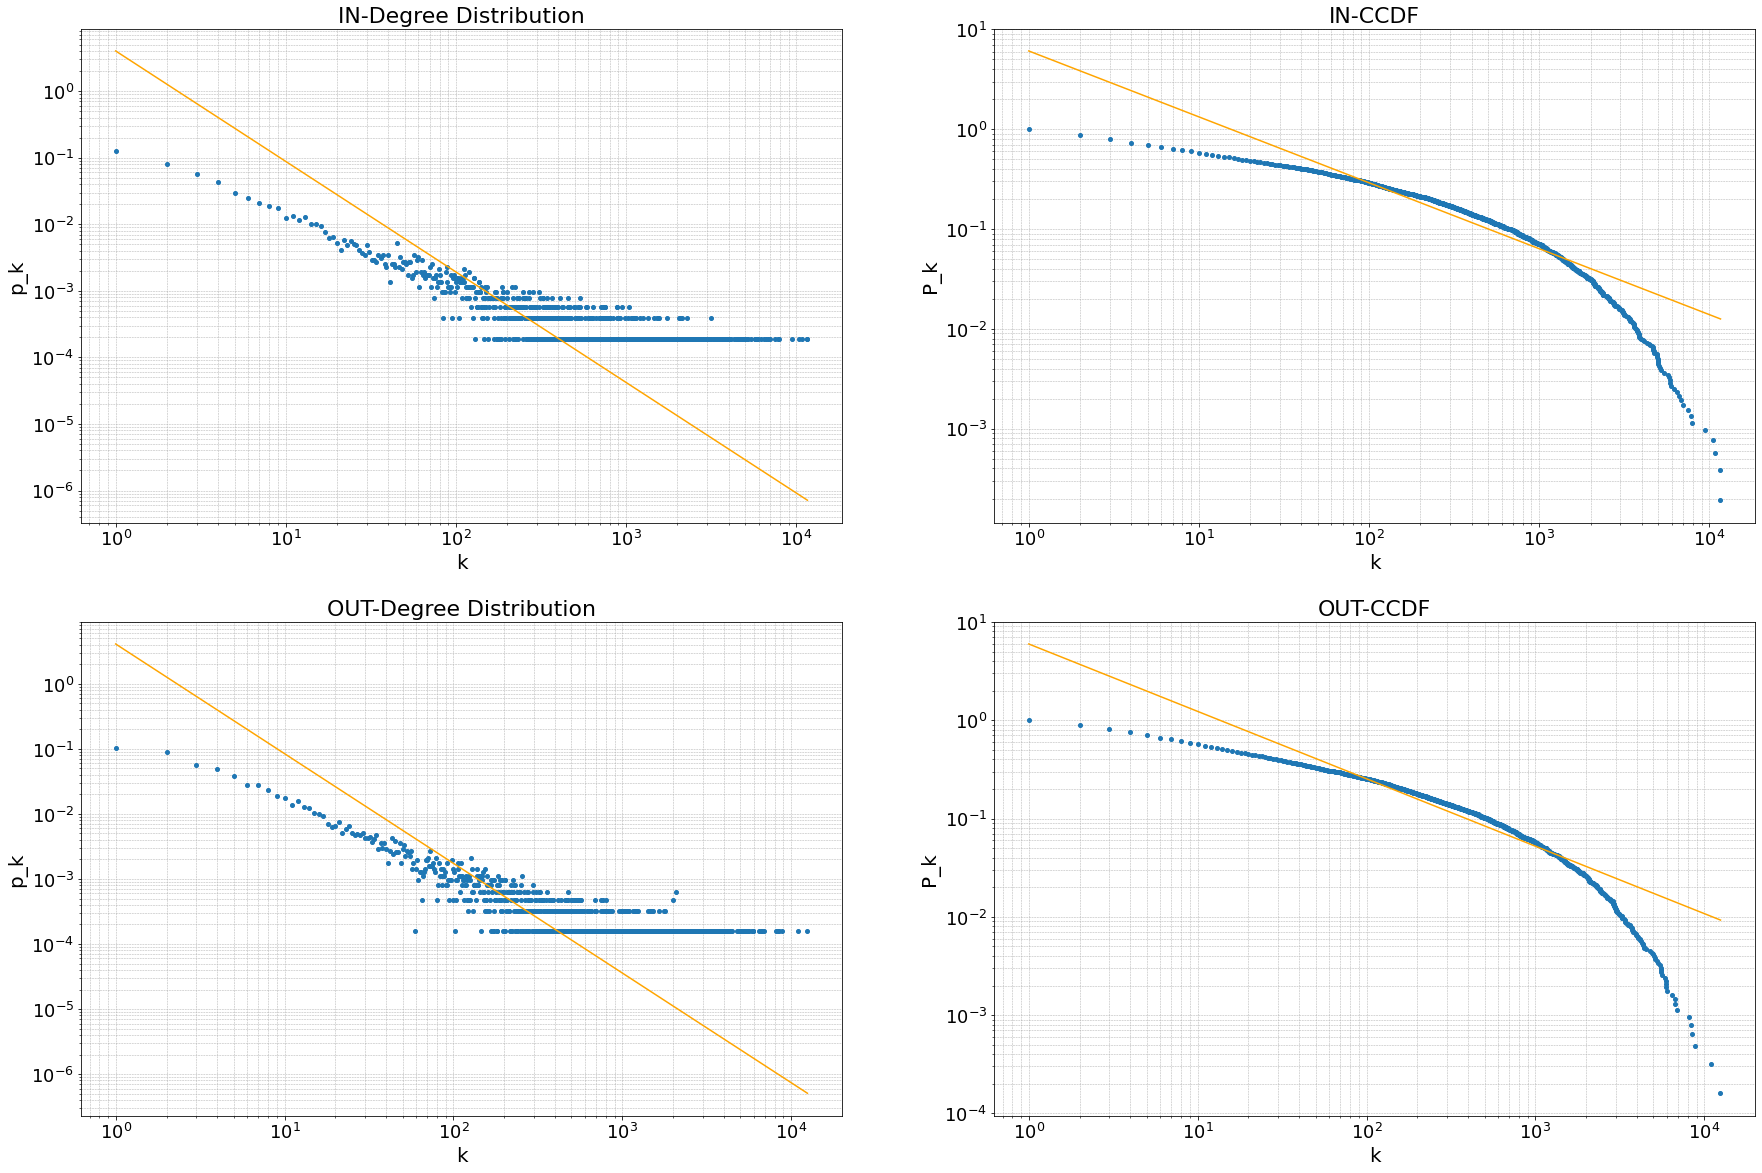

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

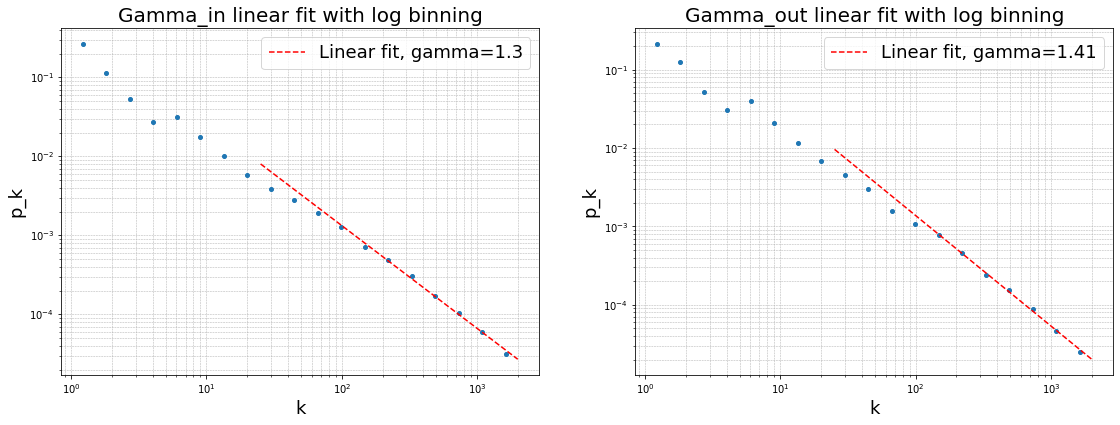

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

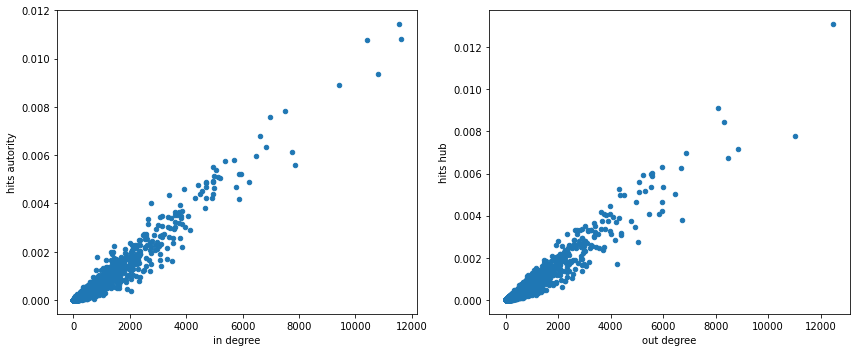

Top 10 for hits hub


,Nodes,hits hub
6985,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013100
3201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.009089
623,UNIVERSITA DEGLI STUDI DI PADOVA,0.008444
5288,UNIVERSIDAD DE GRANADA,0.007785
5800,UNIVERSITAT DE VALENCIA,0.007185
5387,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006954
6238,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006739
2631,UNIVERSIDADE DE LISBOA,0.006314
3364,UNIVERSITA DEGLI STUDI DI TORINO,0.006247
1484,UNIWERSYTET WARSZAWSKI,0.006037


Top 10 for hits autority


,Nodes,hits autority
6985,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011440
5800,UNIVERSITAT DE VALENCIA,0.010822
2631,UNIVERSIDADE DE LISBOA,0.010794
5288,UNIVERSIDAD DE GRANADA,0.009381
6238,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008920
5387,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007841
4816,UNIVERSIDAD DE SEVILLA,0.007591
6746,UNIVERSITAT DE BARCELONA,0.006804
1579,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.006340
3497,UNIVERZA V LJUBLJANI,0.006119


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

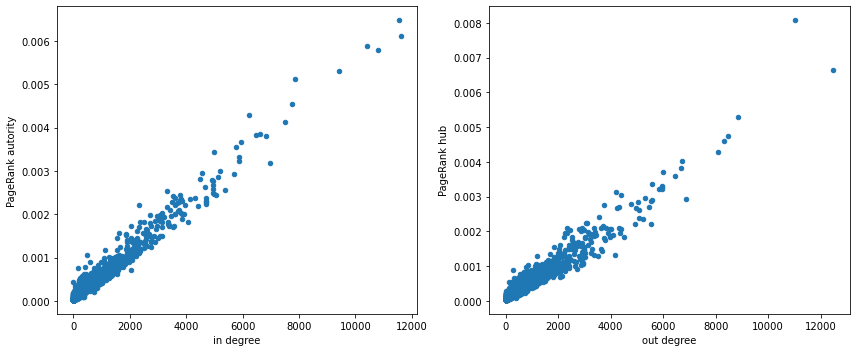

Top 10 for PageRank hub


,Nodes,PageRank hub
5288,UNIVERSIDAD DE GRANADA,0.008073
6985,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006650
5800,UNIVERSITAT DE VALENCIA,0.005288
6238,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004742
623,UNIVERSITA DEGLI STUDI DI PADOVA,0.004605
3201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004285
4514,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.004039
3364,UNIVERSITA DEGLI STUDI DI TORINO,0.003837
3497,UNIVERZA V LJUBLJANI,0.003712
5806,UNIVERSIDAD POLITECNICA DE MADRID,0.003598


Top 10 for PageRank autority


,Nodes,PageRank autority
6985,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006472
5800,UNIVERSITAT DE VALENCIA,0.006109
2631,UNIVERSIDADE DE LISBOA,0.005881
5288,UNIVERSIDAD DE GRANADA,0.005778
6238,UNIVERSIDAD COMPLUTENSE DE MADRID,0.005299
4958,UNIVERSITAT POLITECNICA DE VALENCIA,0.005129
3497,UNIVERZA V LJUBLJANI,0.004541
2911,POLITECNICO DI MILANO,0.004299
5387,KATHOLIEKE UNIVERSITEIT LEUVEN,0.004136
6746,UNIVERSITAT DE BARCELONA,0.003863


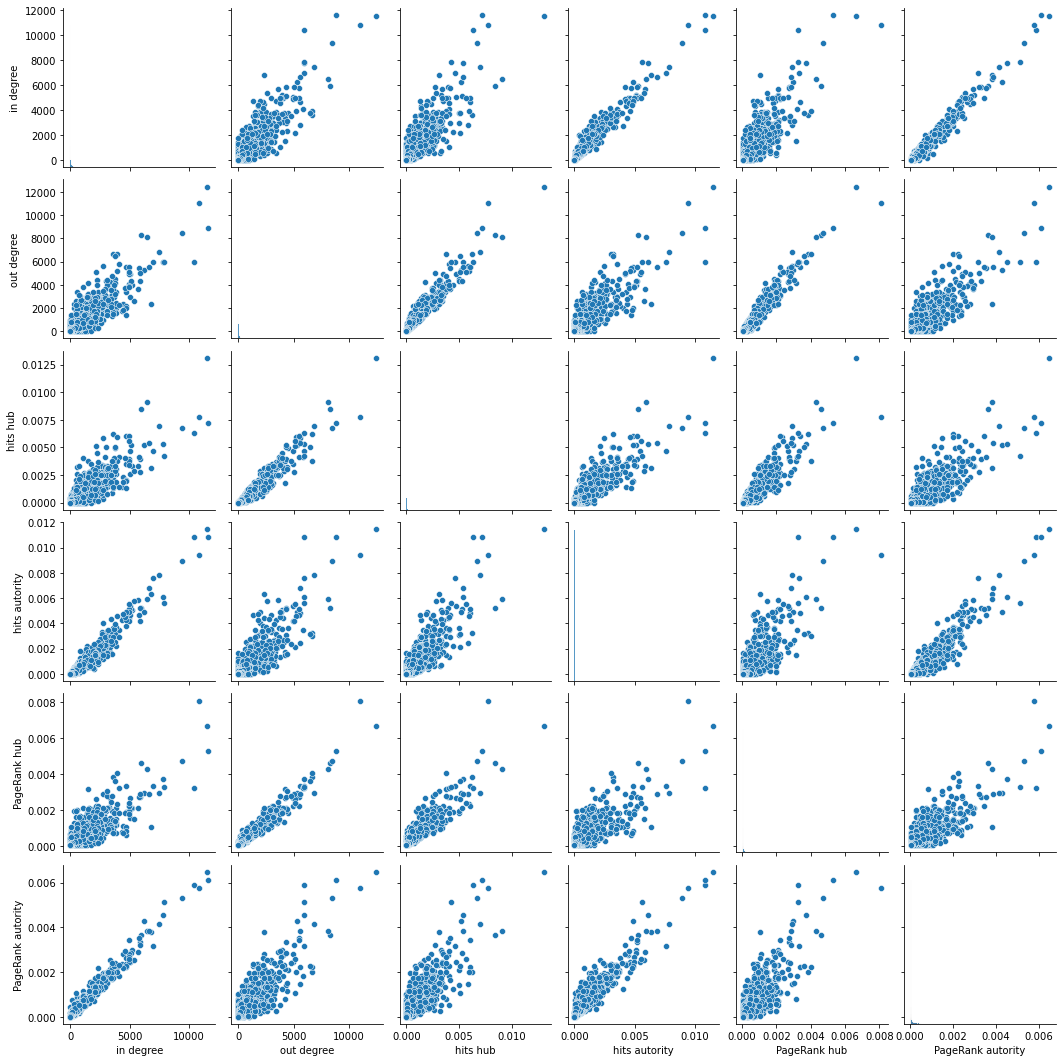

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

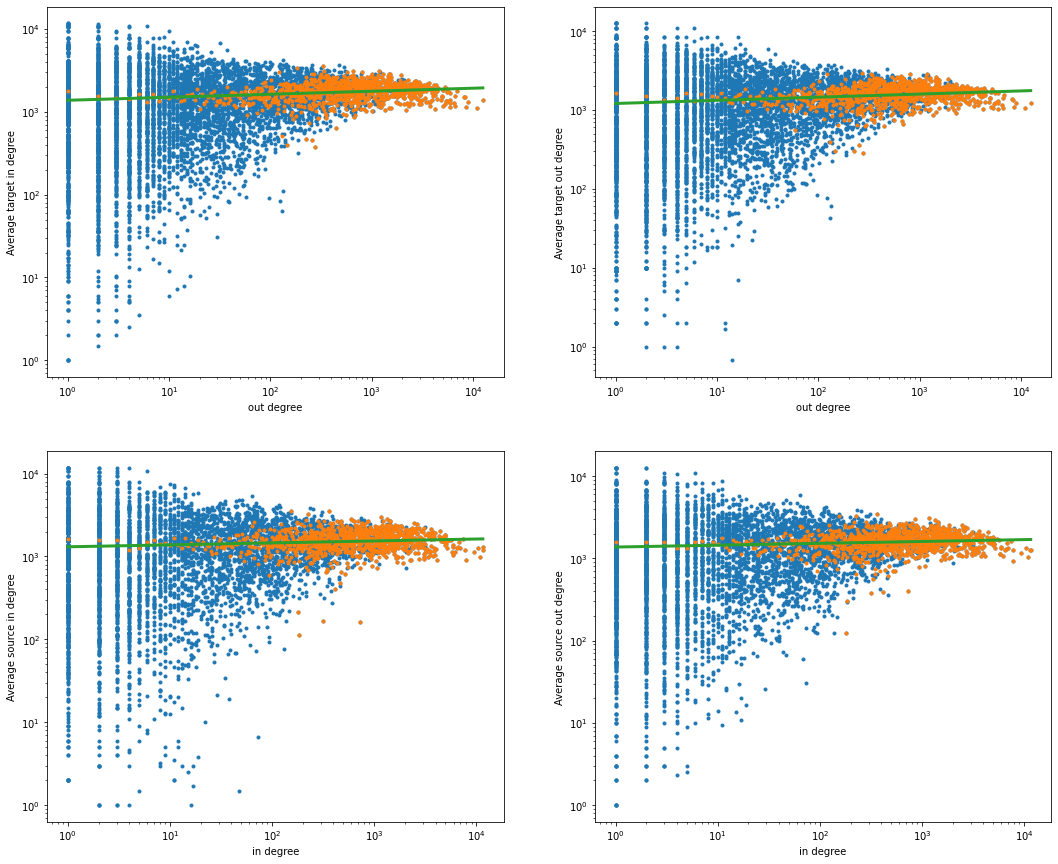

(0.03640513833878805,
 0.039789853926178544,
 0.023463112675281516,
 0.022562450954507176)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

## Communities

In [20]:
import networkx as nx

# G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs, create_using= nx.DiGraph)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['uni_Community'] = node_comm['Community']
# 52 communities. Choose if it makes sense to reduce the number of them 

,Nodes,Community
0,ESCUELA SUPERIOR DE DISEÑO DE LA REGIÓN DE MURCIA,0
4,BEIJING FILM ACADEMY,0
5,УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ УНИВЕРСИТЕТ,0
6,UNIVERSITÉ CENTRALE PRIVÉE DE TUNIS,0
7,KINNERET ACADEMIC COLLEGE IN THE JORDAN VALLEY,0
...,...,...
7103,ASSOCIATION DES FONDATEURS ET PROTECTEURS DE L...,0
7105,PERM NATIONAL RESEARCH POLYTECHNIC UNIVERSITY,0
7106,HOCHSCHULE LUDWIGSHAFEN AM RHEIN,0
7109,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,0


,Nodes,Community
1,UNIWERSYTET KARDYNALA STEFANA WYSZYNSKIEGO W W...,1
2,QUEEN'S UNIVERSITY AT KINGSTON,1
8,"NATIONAL UNIVERSITY CORPORATION, JOETSU UNIVER...",1
13,MUNICH BUSINESS SCHOOL GMBH,1
18,LIEPAJAS JURNIECIBAS KOLEDZA,1
...,...,...
7101,UNIVERSITATEA TITU MAIORESCU,1
7104,ALLAMEH TABATABA'I UNIVERSITY,1
7108,HAUTE ÉCOLE GALILÉE,1
7110,UNIVERSIDAD AUSTRAL DE CHILE,1


,Nodes,Community
38,POPAKADEMIE BADEN-WÜRTTEMBERG GMBH,2
41,THE UNIVERSITY OF WEST LONDON,2
55,INSTITUTO PIAGET - COOPERATIVA PARA DESENVOLVI...,2
60,CONSERVATORIO SUPERIOR DE DANZA DE ALICANTE,2
61,KOYA UNIVERSITY,2
...,...,...
7061,UNIVERSITY OF RAPARIN,2
7092,HAMLINE UNIVERSITY,2
7093,"HOCHSCHULE FUER MUSIK, THEATER UND MEDIEN HANN...",2
7100,FUNDACIÓ CONSERVATORI DEL LICEU,2


,Nodes,Community
17,LATVIJAS SPORTA PEDAGOGIJAS AKADEMIJA,3
34,ECOLE SUPERIEURE EN TRAVAIL EDUCATIF ET SOCIAL...,3
58,EIA - ENSINO E INVESTIGACAO E ADMINISTRACAO SA,3
116,HOCHSCHULE LANDSHUT - HOCHSCHULE FÜR ANGEWANDT...,3
127,AKADEMIA WYCHOWANIA FIZYCZNEGO I SPORTU IM JED...,3
...,...,...
6847,AZERBAIJAN TECHNOLOGICAL UNIVERSITY,3
6966,"ALMA MATER EUROPAEA-EVROPSKI CENTER, MARIBOR",3
6969,HAVERING COLLEGE OF FURTHER AND HIGHER EDUCATION,3
6974,UNIVERSIDAD NACIONAL AUTONOMA DE HONDURAS,3


,Nodes,Community
86,LCC INTERNATIONAL UNIVERSITY,4
253,ECOLE POLYTECHNIQUE PRIVÉE D'AGADIR,4
310,MARIN BARLETI SHA,4
342,IIC UNIVERSITY OF TECHNOLOGY,4
385,IRKUTSK STATE UNIVERSITY OF RAILWAY ENGINEERING,4
...,...,...
6918,SIAS INTERNATIONAL UNIVERSITY,4
6942,ISTANBUL SEHIR UNIVERSITESI,4
6947,KOLEGJI AAB,4
7046,THAI NGUYEN UNIVERSITY,4


,Nodes,Community
51,RUDN UNIVERSITY,5
183,INSTITUT D' ENSEIGNEMENT SUPÉRIEUR DE TRAVAIL ...,5
239,AKADEMIA IM. JANA DLUGOSZA W CZESTOCHOWIE,5
270,TERNOPIL VOLODYMYR HNATIUK NATIONAL PEDAGOGICA...,5
401,VISOKA SKOLA MEDJUNARODNIH ODNOSA I DIPLOMACIJ...,5
...,...,...
6336,HOCHSCHULE DER BUNDESAGENTUR FUER ARBEIT,5
6400,MLC LJUBLJANA,5
6601,YANGON TECHNOLOGICAL UNIVERSITY,5
7053,THEOLOGISCHE UNIVERSITEIT VAN DE GEREFORMEERDE...,5


,Nodes,Community
177,UNIVERSITAET VECHTA,6
265,"UNIVERSIDAD DE PINAR DEL RÍO ""HERMANOS SAÍZ MO...",6
415,UNIVERSITY OF EUROPEAN ECONOMIC AND POLITICAL ...,6
716,UNIVERSIDAD DON BOSCO,6
841,REGIE ECOLE SUPERIEURE DE PHYSIQUE ET DE CHIMI...,6
...,...,...
6447,"GOU VPO ""CHECHENSKIY GOSUDARSTVENNIY UNIVERSITET",6
6712,O.M. BEKETOV NATIONAL UNIVERSITY OF URBAN ECON...,6
6835,PLUMPTON COLLEGE,6
6884,LYCÉE GÉNÉRAL ET TECHNOLOGIQUE JEAN MONNET,6


,Nodes,Community
1418,IES MARIA DE ZAYAS Y SOTOMAYOR,7
1893,CENTRO INTEGRAL DE FP ILERNA S.L.,7
2074,IES HOTEL ESCUELA,7
3076,CENTRE INTEGRAL DE FP ILERNA S.L.,7
3342,SOUTH WEST COLLEGE,7
4682,LYCÉE DES MÉTIERS DE L'HÔTELLERIE ET DU TOURIS...,7
4945,FONDAZIONE ISTITUTO TECNICO SUPERIORE PER TECN...,7


,Nodes,Community
243,UNIVERSITE EZ-ZITOUNA,8
1957,ISLAMIC UNIVERSITY OF APPLIED SCIENCES ROTTERDAM,8
1968,UNIVERSITE ALQUARAOUIYINE,8
3773,INTERNATIONAL CENTRE FOR EDUCATION IN ISLAMIC ...,8
4856,MIDDLE EAST UNIVERSITY,8
5032,UNIVERSITE IBNOU ZOHR A AGADIR,8
6092,ISTANBUL SABAHATTIN ZAIM UNIVERSITY,8


,Nodes,Community
114,ANSGAR TEOLOGISKE HØGSKOLE,9
1397,EESTI EVANGEELIUMI KRISTLASTE JA BAPTISTIDE KO...,9
1624,AKADEMI FÖR LEDARSKAP OCH TEOLOGI,9
1966,LONDON SCHOOL OF THEOLOGY,9
2616,ÖREBRO SCHOOL OF THEOLOGY,9
6110,KAREN BAPTIST THEOLOGICAL SEMINARY,9


,Nodes,Community
3,VISOKA SKOLA ZA MENADZMENT U TURIZMU I INFORMA...,10
207,COLLEGE OF PROFESSIONAL STUDIES IN MANAGEMENT ...,10
231,VISOKA POSLOVNA STRUKOVNIH SKOLA STDIJA U NOVO...,10
2102,"FAKULTETA ZA UPRAVLJANJE, POSLOVANJE IN INFORM...",10
4737,VISOKA SOLA ZA UPRAVLJANJE IN POSLOVANJE NOVO ...,10


,Nodes,Community
1614,IRKUTSK STATE UNIVERSITY,11
3375,HOCHSCHULE ZITTAU/GOERLITZ,11
3477,BAIKAL STATE UNIVERSITY,11
6916,SAINT PETERSBURG NATIONAL RESEARCH UNIVERSITY ...,11
7031,SAINT PETERSBURG NATIONAL RESEARCHUNIVERSITY O...,11


,Nodes,Community
3755,INSTITUT RÉGIONAL DU TRAVAIL SOCIAL NORMANDIE ...,12
4044,INSTITUT RÉGIONAL DU TRAVAIL SOCIAL DE CHAMPAG...,12
6124,HAUTE ECOLE PAUL-HENRI SPAAK,12
6384,HAUTE ECOLE BRUXELLES-BRABANT (HE2B),12


,Nodes,Community
1213,INSTITUT NATIONAL AGRONOMIQUE DE TUNISIE,13
2568,LEBANESE UNIVERSITY,13
3258,CENTRE INTERNATIONAL DES HAUTES ETUDES AGRONOM...,13


,Nodes,Community
95,ECOLE NAVALE GROUPEMENT INTERET PUBLIC,14
1165,ESCOLA NAVAL,14
3627,UNITED STATES NAVAL ACADEMY,14


,Nodes,Community
621,INSTITUT NATIONAL SUPERIEUR DE FORMATION ET DE...,15
2020,"INSTITUT SUPÉRIEUR DE L'EDUCATION SPÉCIALISÉE,...",15
5436,ASTRAKHAN STATE UNIVERSITY,15


,Nodes,Community
870,RELIGIOUS ORGANIZATION OF HIGHER THEOLOGICAL E...,16
1515,ANOTATI ECCLESIASTIKI AKADEMIA THESSALONIKIS,16
5459,KYIV THEOLOGICAL ACADEMY AND SEMINARY OF UKRAI...,16


,Nodes,Community
1373,ACADEMIA DRUZBA ZA STORITVE DOO,17
3469,EUROPEAN UNIVERSITY - REPUBLIC OF MACEDONIA,17
5776,UNIVERSIDAD TECNOLOGICA DE EL SALVADOR,17


,Nodes,Community
286,ECOLE INTERNATIONALE DES SCIENCES DU TRAITEMEN...,18
2796,STATE EDUCATIONAL INSTITUTION OF HIGHER PROFES...,18
6193,NOVOSIBIRSK STATE UNIVERSITY,18


,Nodes,Community
2775,LYCEE OZENNE,19
5617,INSTITUT JOAN BROSSA,19
6669,LYCÉE GEORGES DUBY,19


,Nodes,Community
130,LYCÉE GÉNÉRAL ET TECHNOLOGIQUE JEAN MACE,20
3641,INS JOAQUIM MIR,20
6766,LYCEE LOUISE MICHEL,20


,Nodes,Community
4415,WSZECHNICA POLSKA SZKOLA WYZSZA W WARSZAWIE,21
6196,PUSHKIN STATE RUSSIAN LANGUAGE INSTITUTE,21
6796,UNIVERSIDAD NACIONAL ARTURO JAURETCHE,21


,Nodes,Community
619,HOLAR UNIVERSITY COLLEGE,22
1185,UNIVERSITY OF GUELPH NON-PROFIT CORPORATION,22


,Nodes,Community
1522,EVANGELISCHE HOCHSCHULE FÜR KIRCHENMUSIK TÜBINGEN,23
1915,ERSTA SKÖNDAL BRÄCKE HÖGSKOLA,23


,Nodes,Community
3260,ESCOLA MUNICIPAL D'ART I DISSENY DE TERRASSA,24
3305,ISTITUTO DI CULTURA PANTHEON S.R.L.,24


,Nodes,Community
1847,DUBNICKY TECHNOLOGICKY INSTITUT V DUBNICKI NAD...,25
3313,"VYSOKA SKOLA EVROPSKYCH A REGIONALNICH STUDII,...",25


,Nodes,Community
178,AMERICAN UNIVERSITY OF SCIENCE AND TECHNOLOGY,26
3338,YNCRÉA HAUTS DE FRANCE ISEN-LILLE,26


,Nodes,Community
673,EPLEFPA LOT ET GARONNE,27
3999,INSTITUTO DE EDUCACIÓN SECUNDARIA JUAN CARLOS I,27


,Nodes,Community
304,FONDAZIONE UNICAMPUS SAN PELLEGRINO,28
4384,THE MAXIM GORKY LITERARY INSTITUTE,28


,Nodes,Community
348,SUD MANAGEMENT,29
4651,ACCOUNTANCY & BUSINESS COLLEGE (IRELAND) LIMIT...,29


,Nodes,Community
2050,VYSOKA SKOLA DANUBIUS S.R.O.,30
4785,VOLGA STATE UNIVERSITY OF TECHNOLOGY,30


,Nodes,Community
3744,ACCADEMIA DI BELLE ARTI ALDO GALLI - I.L.E.M. SRL,31
4836,ESCUELA DE ARTE Y SUPERIOR DE CONSERVACIÓN Y R...,31


,Nodes,Community
1050,"VYSOKA SKOLA EVROPSKYCH A REGIONALNICH STUDII,...",32
4968,STREDOEUROPSKA VYSOKA SKOLA V SKALICI,32


,Nodes,Community
341,PETROZAVODSK STATE GLAZUNOV CONSERVATOIRE,33
5444,"ISTITUTO SUPERIORE DI STUDI MUSICALI ""TOSCANINI""",33


,Nodes,Community
1737,VANCOUVER ISLAND UNIVERSITY,34
5468,INSTITUTO DE EDUCACIÓN SECUNDARIA HOZGARGANTA,34


,Nodes,Community
791,PACIFIC LUTHERAN UNIVERSITY,35
5626,MF VITENSKAPELIG HØYSKOLE,35


,Nodes,Community
2398,INSTITUT POBLENOU,36
5728,LYCEE AMPERE,36


,Nodes,Community
1293,PANSTWOWA WYZSZA SZKOLA ZAWODOWA IM. HIPOLITA ...,37
6629,PAVLO TYCHYNA UMAN STATE PEDAGOGICAL UNIVERSITY,37


,Nodes,Community
2417,DAUGAVPILS MEDICAL COLLEGE,38
6750,MEHRABYAN MEDICAL INSTITUTE IN YEREVAN,38


,Nodes,Community
1146,PRIVATUNIVERSITÄT SCHLOSS SEEBURG,39
6791,HOCHSCHULE FÜR ANGEWANDTES MANAGEMENT GMBH,39


,Nodes,Community
2895,"SVEUČILIŠTE/UNIVERZITET ""VITEZ"" VITEZ",40
6933,COLLEGE OF APPLIED SCIENCES LAVOSLAV RUZICKA I...,40


,Nodes,Community
6073,UNIVERSITY OF THE PUNJAB,41


## Geographical heatmap

In [21]:
temp_df = uni_cities[['target', 'Receiving City']].copy()
temp_df.rename({'target':'source', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['source', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)
cities_uni.dropna(subset=['Sending City'], inplace=True)

for index in range(cities_uni.shape[0]):
    city = cities_uni.iat[index,1]
    if city != city.upper():
        cities_uni.iat[index,1] = city.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['source'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City
0,ESCUELA SUPERIOR DE DISEÑO DE LA REGIÓN DE MURCIA,0,25,39,0,1.837930e-05,1.378897e-05,0,0.000062,0.000056,0,MURCIA
1,UNIWERSYTET KARDYNALA STEFANA WYSZYNSKIEGO W W...,1,263,383,1,3.307523e-04,1.555088e-04,1,0.000288,0.000153,1,WARSZAWA
2,QUEEN'S UNIVERSITY AT KINGSTON,2,15,16,2,1.322224e-05,1.129243e-05,2,0.000035,0.000037,1,KINGSTON
3,VISOKA SKOLA ZA MENADZMENT U TURIZMU I INFORMA...,3,5,4,3,1.944948e-12,2.881950e-22,3,0.000074,0.000073,10,VIROVITICA
4,BEIJING FILM ACADEMY,4,0,1,4,5.164813e-08,0.000000e+00,4,0.000033,0.000027,0,BEIJING
...,...,...,...,...,...,...,...,...,...,...,...,...
7108,HAUTE ÉCOLE GALILÉE,7108,58,0,7108,0.000000e+00,3.559362e-05,7108,0.000029,0.000075,1,BRUSSELS
7109,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,7109,46,68,7109,1.938361e-05,1.231106e-05,7109,0.000097,0.000067,0,SAINT PETERSBURG
7110,UNIVERSIDAD AUSTRAL DE CHILE,7110,0,9,7110,2.141655e-06,0.000000e+00,7110,0.000044,0.000027,1,VALDIVIA
7111,TOKYO MEDICAL AND DENTAL UNIVERSITY,7111,3,0,7111,0.000000e+00,6.683369e-08,7111,0.000029,0.000032,0,TOKYO


In [22]:
city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino, Madrid (these are also pretty much important)

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City,city,city_ascii,lat,lng,iso2,admin_name
0,ESCUELA SUPERIOR DE DISEÑO DE LA REGIÓN DE MURCIA,0,25,39,0,1.837930e-05,1.378897e-05,0,0.000062,0.000056,0,MURCIA,MURCIA,Murcia,37.9861,-1.1303,ES,Murcia
1,QUEEN'S UNIVERSITY AT KINGSTON,2,15,16,2,1.322224e-05,1.129243e-05,2,0.000035,0.000037,1,KINGSTON,KINGSTON,Kingston,17.9714,-76.7931,JM,Kingston
2,VISOKA SKOLA ZA MENADZMENT U TURIZMU I INFORMA...,3,5,4,3,1.944948e-12,2.881950e-22,3,0.000074,0.000073,10,VIROVITICA,VIROVITICA,Virovitica,45.8333,17.3833,HR,Virovitičko-Podravska Županija
3,BEIJING FILM ACADEMY,4,0,1,4,5.164813e-08,0.000000e+00,4,0.000033,0.000027,0,BEIJING,BEIJING,Beijing,39.9050,116.3914,CN,Beijing
4,UNIVERSITÉ CENTRALE PRIVÉE DE TUNIS,6,0,3,6,6.773840e-09,0.000000e+00,6,0.000035,0.000027,0,TUNIS,TUNIS,Tunis,36.8008,10.1800,TN,Tunis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,HAUTE ÉCOLE GALILÉE,7108,58,0,7108,0.000000e+00,3.559362e-05,7108,0.000029,0.000075,1,BRUSSELS,BRUSSELS,Brussels,50.8333,4.3333,BE,Brussels-Capital Region
4936,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,7109,46,68,7109,1.938361e-05,1.231106e-05,7109,0.000097,0.000067,0,SAINT PETERSBURG,SAINT PETERSBURG,Saint Petersburg,59.9500,30.3167,RU,Sankt-Peterburg
4937,UNIVERSIDAD AUSTRAL DE CHILE,7110,0,9,7110,2.141655e-06,0.000000e+00,7110,0.000044,0.000027,1,VALDIVIA,VALDIVIA,Valdivia,-39.8142,-73.2459,CL,Los Ríos
4938,TOKYO MEDICAL AND DENTAL UNIVERSITY,7111,3,0,7111,0.000000e+00,6.683369e-08,7111,0.000029,0.000032,0,TOKYO,TOKYO,Tokyo,35.6897,139.6922,JP,Tōkyō


Importing geographic data also for countries

In [23]:
import geopandas as gpd
import pycountry as pc #library used for translating country codes from iso3 to iso2 standard

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
# geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
# geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# merge geometries with our dataframe
geo_scores = pd.merge(left=scores_cities, right=geo_df[['iso2_code', 'geometry']], how='left', 
                      left_on='iso2', right_on='iso2_code')
geo_scores = geo_scores[['Nodes', 'PageRank hub', 'PageRank autority', 'City', 'lat', 'lng',
                         'iso2', 'geometry', 'uni_Community']]

Dividing universities by their country community

In [24]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
c_nodes = np.array(list(pd.concat([country_df.loc[:, country_df.columns[0]], country_df.loc[:, country_df.columns[1]]]).drop_duplicates()))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))

# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
# G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix)
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix, create_using= nx.DiGraph)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()
# some countries have a different code
country_comm.loc[country_comm['Nodes'] == 'UK', 'Nodes'] = 'GB'
country_comm.loc[country_comm['Nodes'] == 'EL', 'Nodes'] = 'GR'

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')



for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

,Nodes,Community
1,IT,0
2,AT,0
6,ET,0
10,TH,0
11,KG,0
...,...,...
145,BI,0
149,MR,0
150,PA,0
151,BB,0


,Nodes,Community
0,EE,1
3,CN,1
4,RU,1
5,CU,1
7,RS,1
...,...,...
134,SK,1
146,BN,1
147,TL,1
148,BW,1


,Nodes,Community
22,UZ,2
38,BF,2
51,FR,2
74,NE,2
79,SG,2
...,...,...
130,SE,2
131,ZW,2
133,VE,2
138,CI,2


,Nodes,Community
29,BE,3
41,CD,3
45,SR,3
47,AL,3
62,DO,3
63,XK,3
68,BJ,3
82,KH,3
118,LT,3
137,GM,3


Focus on european countries

In [25]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha
country_comm['Nodes'] = list(map(lambda x: replace_iso3166(x), country_comm['Nodes']))
country_comm = country_comm[country_comm['Nodes'].str.contains('|'.join(eu_countries))==True]
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])
    print(country_comm[country_comm['Community']==i].to_latex())

,Nodes,Community
1,Italy,0
2,Austria,0
50,Czechia,0
52,Denmark,0
64,Germany,0
...,...,...
98,Finland,0
106,Hungary,0
125,Poland,0
135,United Kingdom,0


\begin{tabular}{llr}
\toprule
{} &           Nodes &  Community \\
\midrule
1   &           Italy &          0 \\
2   &         Austria &          0 \\
50  &         Czechia &          0 \\
52  &         Denmark &          0 \\
64  &         Germany &          0 \\
77  &           Spain &          0 \\
98  &         Finland &          0 \\
106 &         Hungary &          0 \\
125 &          Poland &          0 \\
135 &  United Kingdom &          0 \\
153 &     Switzerland &          0 \\
\bottomrule
\end{tabular}



,Nodes,Community
0,Estonia,1
7,Serbia,1
9,Ukraine,1
19,Bosnia and Herzegovina,1
23,Montenegro,1
...,...,...
122,Malta,1
124,Norway,1
129,Turkey,1
132,Slovenia,1


\begin{tabular}{llr}
\toprule
{} &                   Nodes &  Community \\
\midrule
0   &                 Estonia &          1 \\
7   &                  Serbia &          1 \\
9   &                 Ukraine &          1 \\
19  &  Bosnia and Herzegovina &          1 \\
23  &              Montenegro &          1 \\
30  &    Moldova, Republic of &          1 \\
46  &                Bulgaria &          1 \\
54  &                 Belarus &          1 \\
78  &                  Greece &          1 \\
105 &                 Croatia &          1 \\
107 &                Portugal &          1 \\
108 &                 Romania &          1 \\
110 &                 Ireland &          1 \\
112 &                 Iceland &          1 \\
117 &           Liechtenstein &          1 \\
119 &              Luxembourg &          1 \\
120 &                  Latvia &          1 \\
121 &         North Macedonia &          1 \\
122 &                   Malta &          1 \\
124 &                  Norway &          1

,Nodes,Community
51,France,2
123,Netherlands,2
130,Sweden,2


\begin{tabular}{llr}
\toprule
{} &        Nodes &  Community \\
\midrule
51  &       France &          2 \\
123 &  Netherlands &          2 \\
130 &       Sweden &          2 \\
\bottomrule
\end{tabular}



,Nodes,Community
29,Belgium,3
47,Albania,3
118,Lithuania,3


\begin{tabular}{llr}
\toprule
{} &      Nodes &  Community \\
\midrule
29  &    Belgium &          3 \\
47  &    Albania &          3 \\
118 &  Lithuania &          3 \\
\bottomrule
\end{tabular}



(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

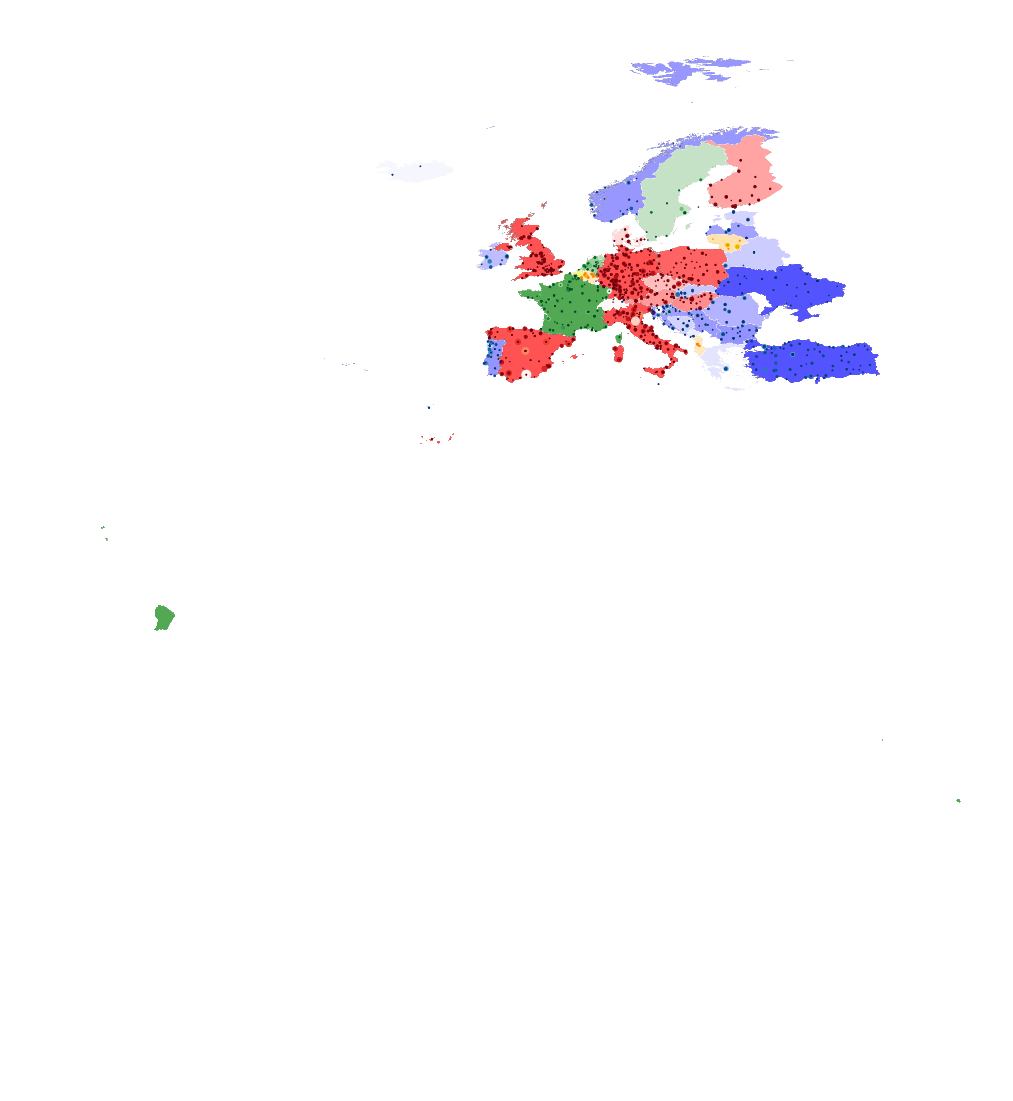

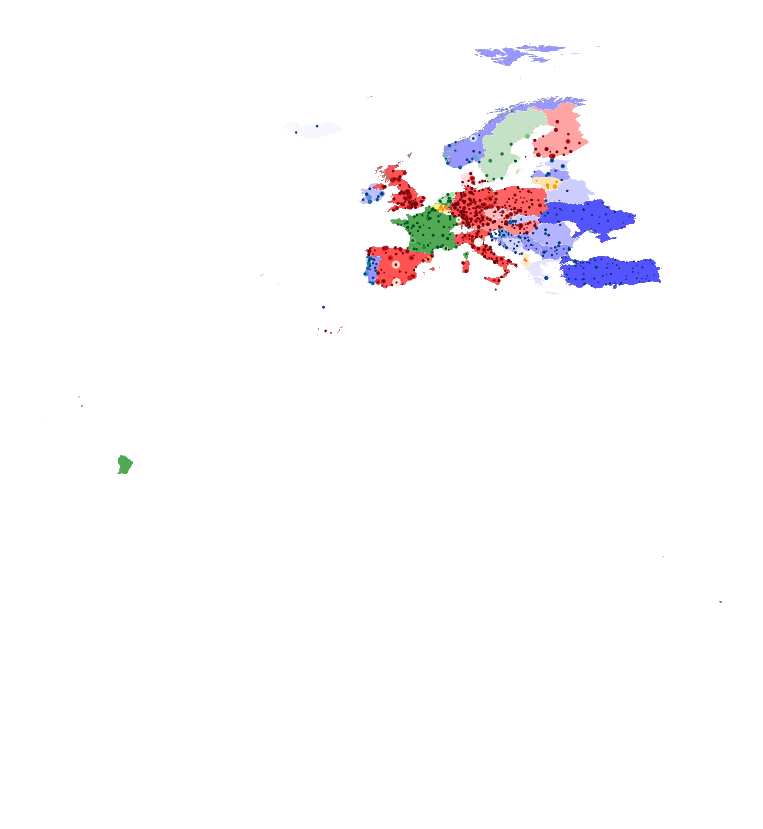

In [26]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Wistia_r', 'Purples_r', 'Greys_r']

fig, ax = plt.subplots(figsize=(20,20))

for c in range(4):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
ax.axis('off')

#plt.savefig('countries_communities & universities_hubs.png')

fig, ax = plt.subplots(figsize=(20,20))

for c in range(4):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank autority']*10**4, c=temp_df['PageRank autority'],
                  cmap=cmaps[c])
ax.axis('off')

#plt.savefig('countries_communities & universities_authorities.png')

### Universities communities geographic plot

(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

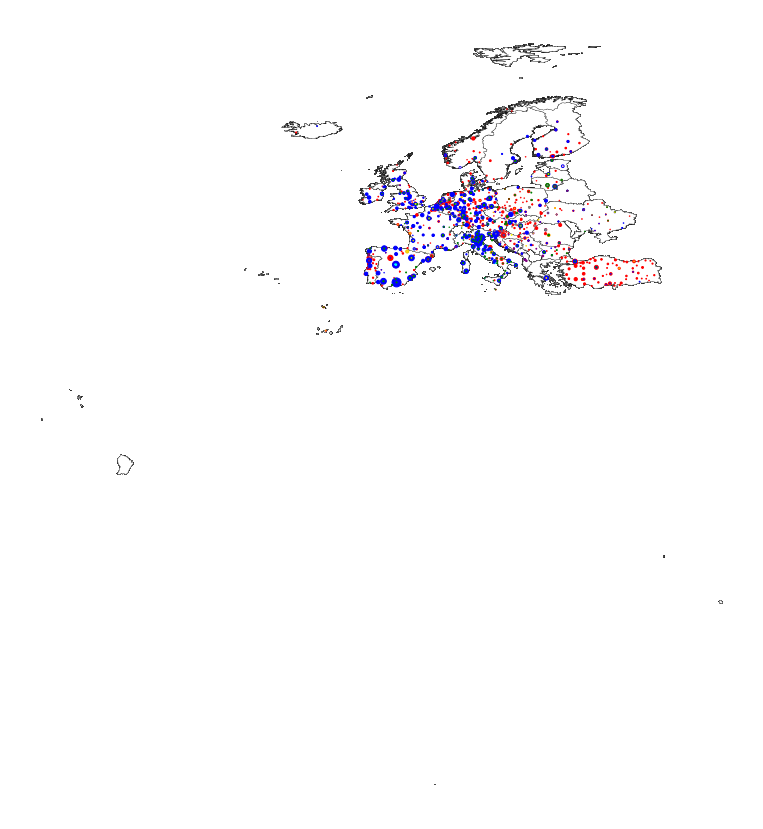

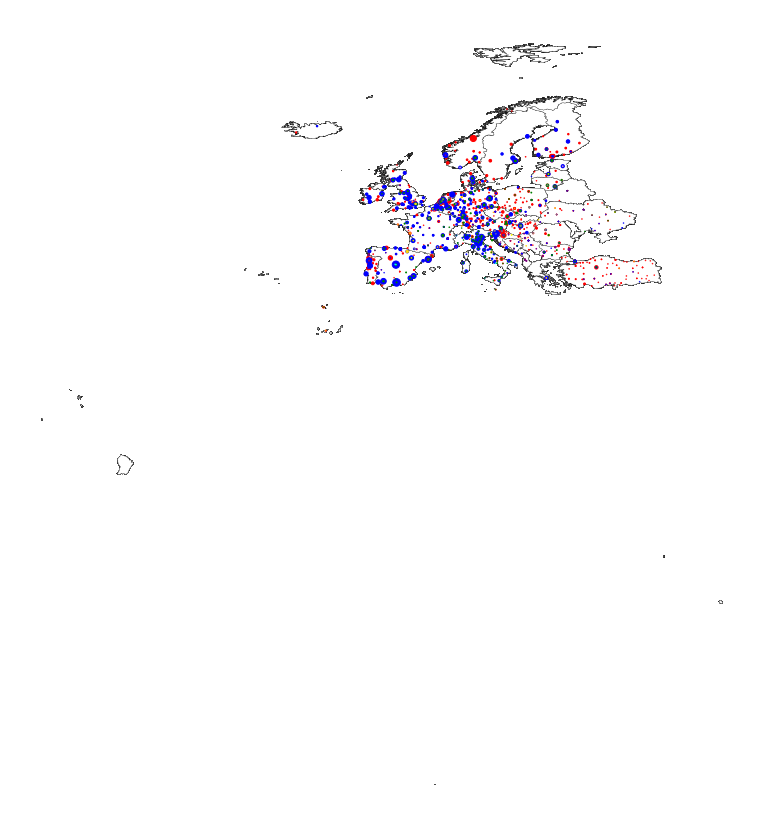

In [27]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey', 'gold', 'aqua', 'fuchsia', 'pink', 'yellow', 'salmon', 
          'khaki', 'brown', 'lime', 'skyblue', 'peachpuff', 'ivory', 'powderblue', 'rosybrown', 'royalblue', 
          'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue',
          'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet',
          'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 
          'lightseagreen', 'lightskyblue', 'lightslategray']

geo_plt = geo_scores.copy()
# dropping all communities containing number of universities lower or equal than 2
for c in range(max(geo_plt['uni_Community'])):
    if geo_plt[geo_plt['uni_Community'] == c].shape[0] <= 2:
        geo_plt = geo_plt[geo_plt['uni_Community'] != c]
geo_plt = gpd.GeoDataFrame(geo_plt, geometry='geometry')

# universities sized on PageRank hub score
fig, ax = plt.subplots(figsize=(20,15))

geo_plt.plot(ax=ax, edgecolor='0.1', linewidth=0.3, color='1')

# sns.scatterplot(x='lng', y='lat', data=geo_plt, hue='uni_Community', legend=False, ax=ax, size=geo_plt['PageRank hub']*10**4)
# ax.scatter(x=geo_plt['lng'], y=geo_plt['lat'], s=geo_plt['PageRank hub']*10**4, c=geo_plt['uni_Community'], cmap='jet')

for c in list(geo_plt['uni_Community'].unique()):
    temp_df = geo_plt[geo_plt['uni_Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'], cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'])
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, color=colors[c])
ax.axis('off')

# plt.savefig('universities_communities_hubs.png')

# universities sized on PageRank authority score
fig, ax = plt.subplots(figsize=(20,15))

geo_plt.plot(ax=ax, edgecolor='0.1', linewidth=0.3, color='1')

for c in list(geo_plt['uni_Community'].unique()):
    temp_df = geo_plt[geo_plt['uni_Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank autority']*10**4, color=colors[c])
ax.axis('off')

# plt.savefig('universities_communities_authorities.png')

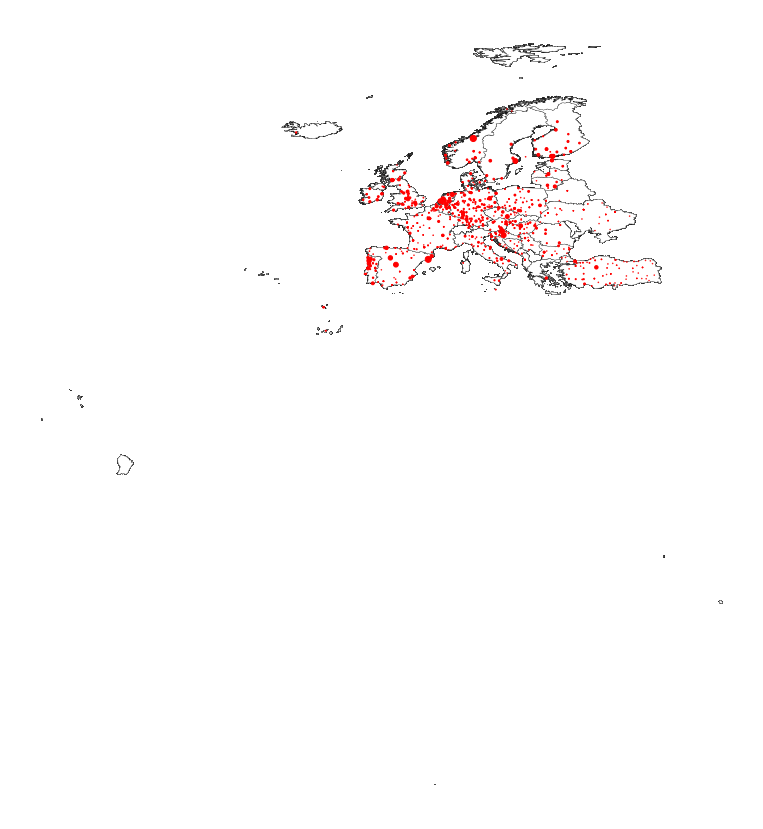

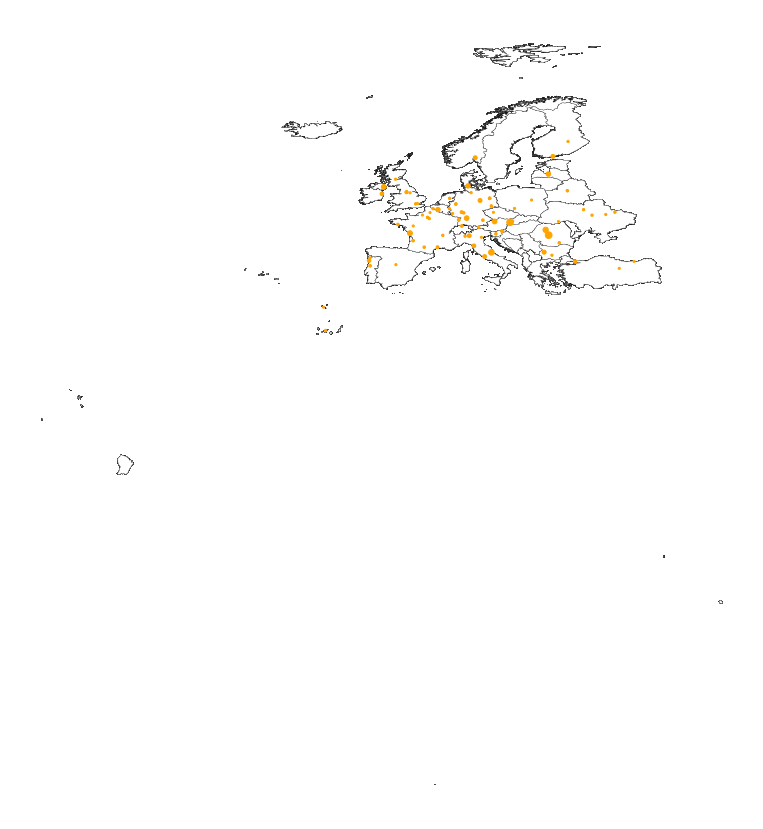

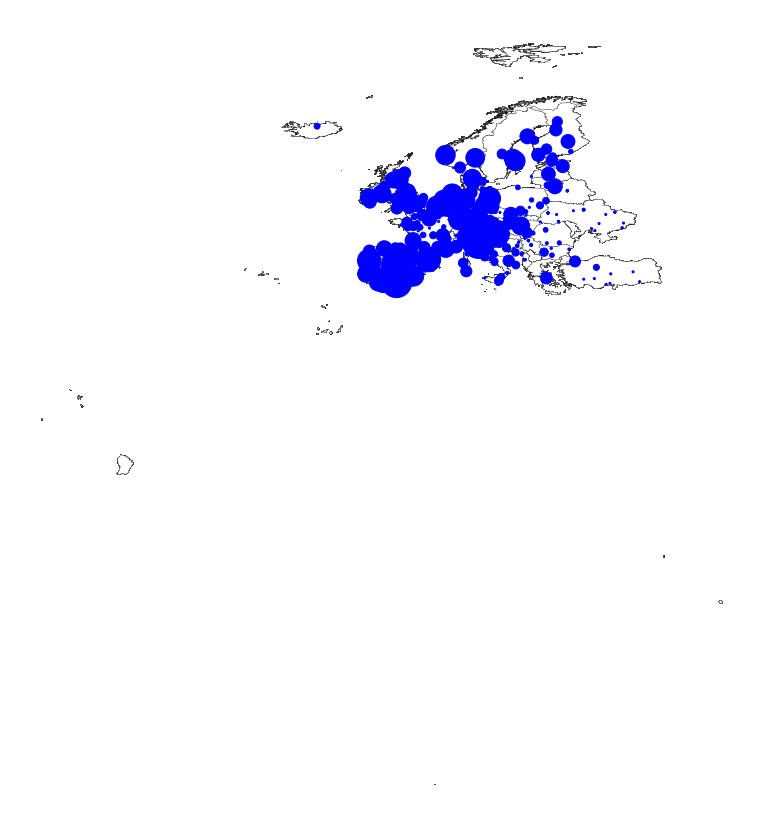

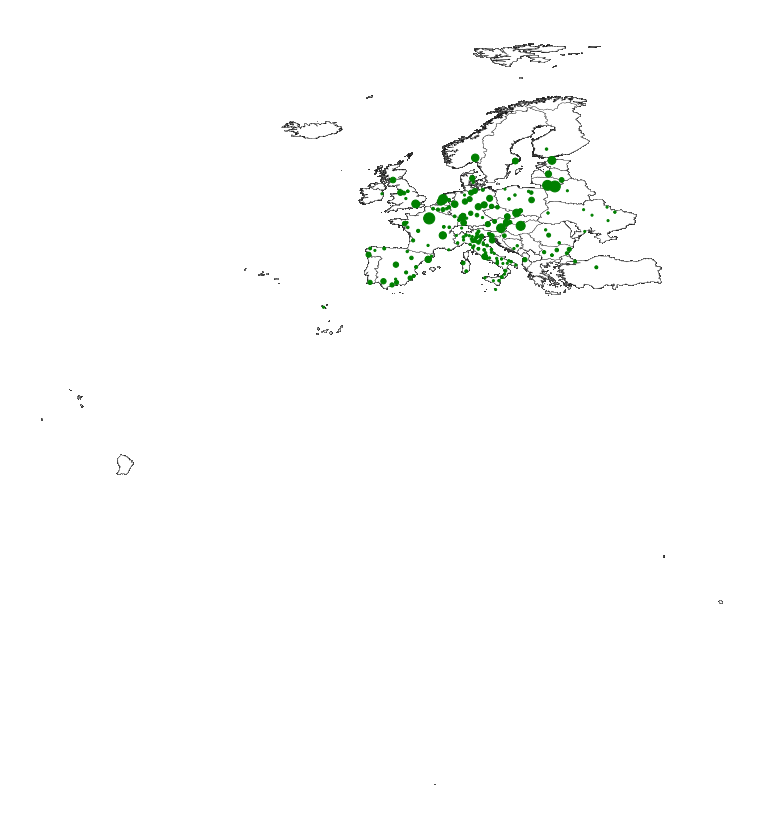

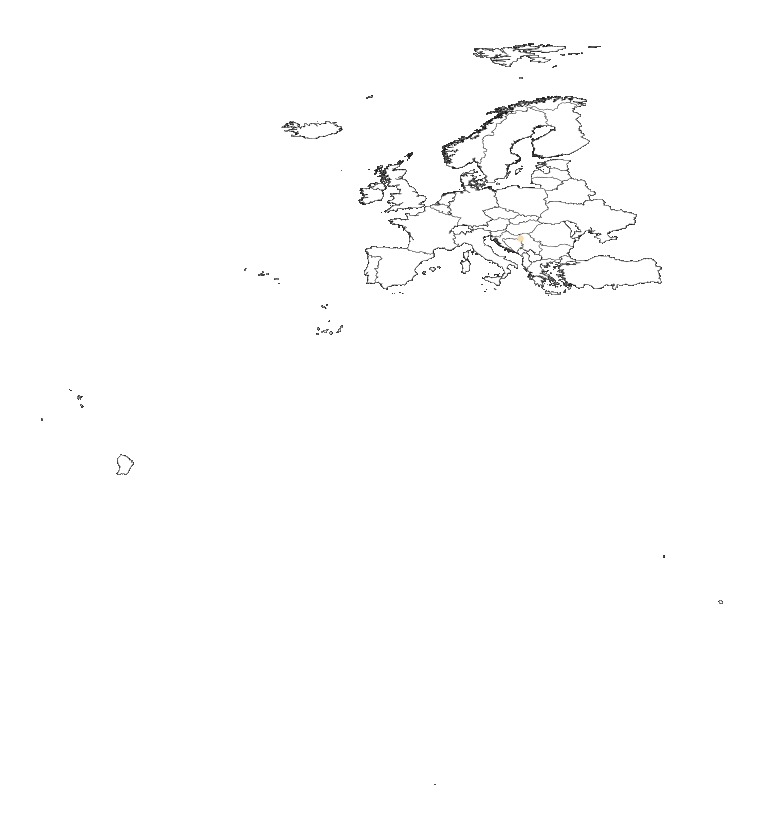

In [31]:
# dropping all communities containing number of universities lower or equal than 50
for c in range(max(geo_plt['uni_Community'])):
    if geo_plt[geo_plt['uni_Community'] == c].shape[0] <= 50:
         geo_plt = geo_plt[geo_plt['uni_Community'] != c]
i=10
for c in list(geo_plt['uni_Community'].unique()):
    fig, ax = plt.subplots(figsize=(20,15))
    geo_plt.plot(ax=ax, edgecolor='0.1', linewidth=0.3, color='1')
    temp_df = geo_plt[geo_plt['uni_Community'] == c]
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    if(c>1):
        i=20
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank autority']*i**4, color=colors[c])
    ax.axis('off')


### Robustness

In [29]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [30]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tomma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomma\AppData\Local\Temp/ipykernel_11620/3591738658.py", line 14, in <module>
    col = np.array(temp_serie.index.get_level_values(0).tolist())
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tomma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tomma\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
 

TypeError: object of type 'NoneType' has no len()

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()